In [36]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow.keras.utils
import matplotlib.pyplot as plt
import seaborn as sns

# Split the Data

In [25]:
# Directories containing preprocessed images
save_directory_real = '../data/interim/face_processed/real'
save_directory_fake = '../data/interim/face_processed/fake'

# Function to create a DataFrame with image paths and labels
# Changing labelling to be 1 if fake and 0 if real
def create_image_label_df(real_dir, fake_dir):
    real_images = [(os.path.join(real_dir, f), 0) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]
    fake_images = [(os.path.join(fake_dir, f), 1) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]
    
    # Combine real and fake images into one DataFrame
    df = pd.DataFrame(real_images + fake_images, columns=['image_path', 'label'])
    return df

# Create the DataFrame
images_df = create_image_label_df(save_directory_real, save_directory_fake)

In [26]:
# Splitting the data into features and target arrays
X = images_df['image_path'].values
y = images_df['label'].values

# First split to separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Second split to separate out the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp, shuffle=True)  # 0.25 x 0.8 = 0.2

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

'''
Training Set: 60% of the original dataset.
Validation Set: 20% of the original dataset.
Testing Set: 20% of the original dataset.
'''

Training set size: 2400
Validation set size: 800
Testing set size: 800


'\nTraining Set: 60% of the original dataset.\nValidation Set: 20% of the original dataset.\nTesting Set: 20% of the original dataset.\n'

# Loading images for modelling

In [27]:
def load_images(image_paths, labels):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(128, 128), color_mode='grayscale') #Note: gray scale and size pre-processed alr
        img_array = img_to_array(img)/255.0 #Convert image to array + normalise 
        images.append(img_array) 
    return np.array(images), np.array(labels)

# Load and get images in dataset (From path)
X_train_processed, y_train_processed = load_images(X_train, y_train)
X_val_processed, y_val_processed = load_images(X_val, y_val)
X_test_processed, y_test_processed = load_images(X_test, y_test)

In [28]:
X_train_processed.shape

(2400, 128, 128, 1)

# Modelling

- Base Model

In [37]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),activation='relu',kernel_initializer='he_uniform', padding='same',input_shape=(128,128,1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation="relu", kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                      

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', 
                  patience=10,
                  restore_best_weights=True,verbose=0),
    ReduceLROnPlateau(monitor = 'val_accuracy',patience=2,
                      factor=0.5,
                      min_lr = 0.00001,
                      verbose = 1)
]

In [40]:
mod_hist = model.fit(X_train_processed, y_train_processed,
                    epochs=30, batch_size=32, 
                    validation_data=(X_val_processed, y_val_processed),
                    callbacks = callbacks_list)

Epoch 1/30
75/75 [==============================] - 66s 863ms/step - loss: 0.9058 - accuracy: 0.5433 - val_loss: 0.7532 - val_accuracy: 0.5437 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - 80s 1s/step - loss: 0.7750 - accuracy: 0.5867 - val_loss: 0.7093 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 3/30
75/75 [==============================] - 93s 1s/step - loss: 0.7136 - accuracy: 0.6104 - val_loss: 0.6535 - val_accuracy: 0.6338 - lr: 0.0010
Epoch 4/30
75/75 [==============================] - 130s 2s/step - loss: 0.6639 - accuracy: 0.6404 - val_loss: 0.6282 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 5/30
75/75 [==============================] - 127s 2s/step - loss: 0.6035 - accuracy: 0.6808 - val_loss: 0.6539 - val_accuracy: 0.6737 - lr: 0.0010
Epoch 6/30
75/75 [==============================] - 126s 2s/step - loss: 0.5680 - accuracy: 0.7038 - val_loss: 0.6044 - val_accuracy: 0.6950 - lr: 0.0010
Epoch 7/30
75/75 [==============================] - 124s 2s/step - loss: 0.5

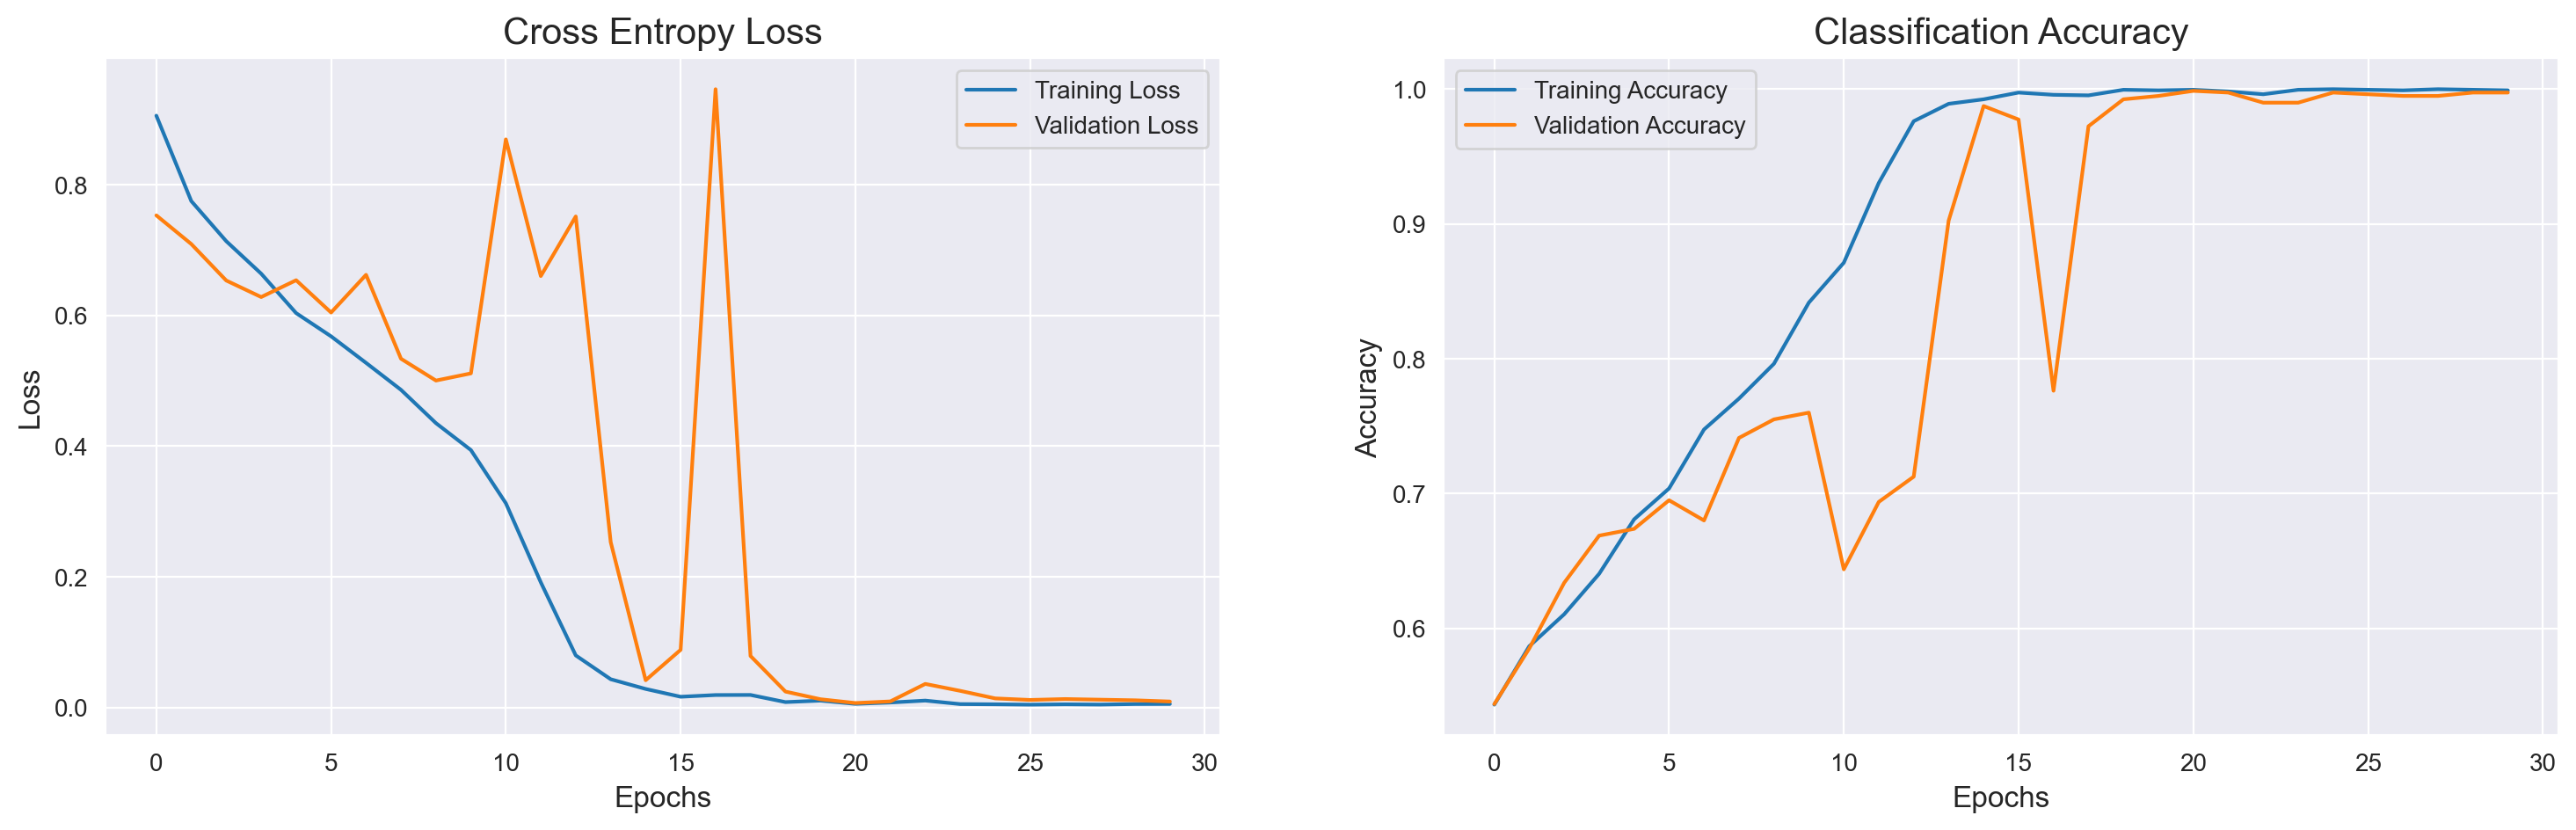

In [41]:
# plots for accuracy and Loss with epochs
error = pd.DataFrame(mod_hist.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'], label='Training Loss')
plt.plot(error['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'], label='Training Accuracy')
plt.plot(error['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [42]:
loss, accuracy = model.evaluate(X_test_processed, y_test_processed)
print(accuracy)

25/25 [==============================] - 24s 965ms/step - loss: 0.0096 - accuracy: 0.9950
0.9950000047683716


In [43]:
#Classes: fake == 1, real==0 (changed for preprocessed data above to follow this)
y_probab = model.predict(X_test_processed) # probability of class = 1
print(y_probab)

25/25 [==============================] - 26s 1s/step
[[9.99959111e-01]
 [9.99999762e-01]
 [1.76134941e-04]
 [9.99858677e-01]
 [9.99994993e-01]
 [9.99998033e-01]
 [2.00901268e-04]
 [9.99983966e-01]
 [2.46205109e-05]
 [9.99974668e-01]
 [2.55646912e-04]
 [2.78763734e-02]
 [2.71905679e-03]
 [4.12609754e-03]
 [9.76999104e-03]
 [9.99993503e-01]
 [9.99984324e-01]
 [6.63977873e-04]
 [9.99976397e-01]
 [1.08575507e-03]
 [2.67881787e-05]
 [9.99991417e-01]
 [3.39018385e-04]
 [2.75657767e-05]
 [9.99973238e-01]
 [2.94946879e-03]
 [9.99834001e-01]
 [1.36259000e-03]
 [9.36675817e-02]
 [9.99995708e-01]
 [8.47192132e-05]
 [1.00000000e+00]
 [9.99933183e-01]
 [9.99992788e-01]
 [9.99849558e-01]
 [6.45408581e-05]
 [9.99980688e-01]
 [6.35518059e-02]
 [9.99977171e-01]
 [9.99999881e-01]
 [9.99439657e-01]
 [9.99848366e-01]
 [6.70403824e-04]
 [1.85702986e-03]
 [1.62541284e-03]
 [9.99999762e-01]
 [8.63855937e-04]
 [5.06494034e-05]
 [9.43730213e-03]
 [9.99982536e-01]
 [1.31031498e-03]
 [9.99997914e-01]
 [9.9999964